In [1]:
import argparse, os, copy, random, sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from functools import partial
from tqdm import *
import dataset, utils_CGCD, losses, net
from net.resnet import *
from models.modelgen import ModelGen, ModelGen_new
from torchsummary import summary

from autoencoder import Autoencoder

import seaborn as sns
from matplotlib.pylab import plt

np.set_printoptions(threshold=sys.maxsize)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)



def generate_dataset(dataset, index, index_target=None, target=None):
    dataset_ = copy.deepcopy(dataset)

    if target is not None:
        for i, v in enumerate(index_target):
            dataset_.ys[v] = target[i]

    for i, v in enumerate(index):
        # print("Index ",index, "Dataset.I",dataset_.I)
        j = v - i    # We seperate i because as we pop a element outside the array moves towards left and its size decreases
        dataset_.I.pop(j)
        dataset_.ys.pop(j)
        # dataset_.im_paths.pop(j)
    return dataset_


def merge_dataset(dataset_o, dataset_n):
    dataset_ = copy.deepcopy(dataset_o)
    # if len(dataset_n.classes) > len(dataset_.classes):
    #     dataset_.classes = dataset_n.classes
    dataset_.I.extend(dataset_n.I)
    # dataset_.I  = list(set(dataset_n.I))
    # dataset_.im_paths.extend(dataset_n.im_paths)
    dataset_.ys.extend(dataset_n.ys)

    return dataset_


class MyDict(dict):
    def __init__(self, args):
        self.args

class BlankClass:
    pass

args = BlankClass()


args.sz_batch  = 256
args.nb_epochs = 60
args.nb_workers = 0
args.loss = "Proxy_Anchor"
args.optimizer = "adamw"
args.lr = 1e-2 
args.weight_decay = 1e-7
args.lr_decay_step = 5
args.lr_decay_gamma =  0.5
args.alpha = 32
args.mrg = 0.1
args.warm = 5
args.bn_freeze = False 
args.l2_norm =  True
args.use_split_modlue =  True
args.use_GM_clustering =  True
args.exp = '0'

In [2]:

# import os
# # old_file = os.path.join("directory", "a.txt")
# # new_file = os.path.join("directory", "b.kml")
# # os.rename(old_file, new_file)
# a = os.listdir('AutoEncoders/pamap/')

# for file_name in os.listdir('AutoEncoders/pamap/'):
        
#     os.rename('AutoEncoders/pamap/' +file_name, 'AutoEncoders/pamap/'+file_name+'_AEType_normal.pth')


In [3]:
# Hard Coded Variables.

args.dataset = 'pamap'   # Dataset 
only_test = False            # Just to test the data on Train_1
args.model = 'resnet18'        # Model Name
window_len = 200
args.use_split_modlue = True
args.sz_embedding = 256

In [6]:
pth_rst = 'CGCD-main/src/result/' + args.dataset
os.makedirs(pth_rst, exist_ok=True)
pth_rst_exp = 'Saved_Models/Initial/CGCD/' + args.dataset + '/' #+ args.model + '_sp_' + str(args.use_split_modlue) + '_gm_' + str(args.use_GM_clustering) + '_' + args.exp
os.makedirs(pth_rst_exp, exist_ok=True)

print("Dataset :", args.dataset)
####

pth_dataset = '../datasets'
if args.dataset == 'cub':
    pth_dataset += '/CUB200'
elif args.dataset == 'mit':
    pth_dataset += '/MIT67'
elif args.dataset == 'dog':
    pth_dataset += '/DOG120'
elif args.dataset == 'air':
    pth_dataset += '/AIR100'
elif args.dataset == 'adl':
    
    pth_dataset = 'netscratch/martelleto/iswc/ssl-data/downstream/adl_30hz_clean/'
elif args.dataset =='wisdm':
    pth_dataset = 'HAR_data/Wisdm/'
elif args.dataset =='realworld':
    pth_dataset = 'HAR_data/realworld/'
    nb_classes_now = 8
elif args.dataset =='oppo':
    pth_dataset = 'HAR_data/oppo/'
elif args.dataset =='pamap':
    pth_dataset = 'HAR_data/pamap/'
    n_channels = 9

Dataset : pamap


In [7]:
dset_tr_0 = dataset.load(name=args.dataset, root=pth_dataset, mode='train_0', windowlen= window_len)
dlod_tr_0 = torch.utils.data.DataLoader(dset_tr_0, batch_size=args.sz_batch, shuffle=True, num_workers=args.nb_workers)

dset_ev = dataset.load(name=args.dataset, root=pth_dataset, mode='eval_0', windowlen=window_len)
dlod_ev = torch.utils.data.DataLoader(dset_ev, batch_size=args.sz_batch, shuffle=False, num_workers=args.nb_workers)

dset_test_0 = dataset.load(name=args.dataset, root=pth_dataset, mode='test_0', windowlen=window_len)
dlod_test_0 = torch.utils.data.DataLoader(dset_test_0, batch_size=args.sz_batch, shuffle=False, num_workers=args.nb_workers)


nb_classes = dset_tr_0.nb_classes()


if(args.model == 'resnet18'):
    cfg = {'weights_path': 'Saved_Models/UK_BioBank_pretrained/mtl_best.mdl', "use_ssl_weights" : False, 'conv_freeze': False, 'load_finetuned_mtl': False,
        'checkpoint_name' :'', 'epoch_len': 2, 'output_size': '', 'embedding_dim': args.sz_embedding, 'bottleneck_dim': 1,
            'output_size':nb_classes,'weight_norm_dim': '',  'n_channels' :n_channels, 'window_len': window_len}

    model = ModelGen_new(cfg).create_model().to(device)

if(args.model == 'harnet'):
    repo = 'OxWearables/ssl-wearables'
    model = torch.hub.load(repo, 'harnet5', class_num=nb_classes, pretrained=False).to(device)
    del model.classifier
    model.embedding = nn.Sequential(nn.Linear(model.feature_extractor.layer5[0].out_channels,args.sz_embedding)).to(device)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}
outout of FE torch.Size([64, 128, 5])
With Embedding
No of classes : -> 12


In [8]:
criterion_pa = losses.Proxy_Anchor(nb_classes=nb_classes, sz_embed=args.sz_embedding , mrg=args.mrg, alpha=args.alpha).to(device)

#### Train Parameters
gpu_id =0
param_groups = [
    {'params': list(set(model.parameters()).difference(set(model.embedding.parameters()))) if gpu_id != -1 else list(set(model.module.parameters()).difference(set(model.module.model.embedding.parameters())))},
    {'params': model.embedding.parameters() if gpu_id != -1 else model.embedding.parameters(), 'lr': float(args.lr) * 1},]
# param_groups = [{'params': model.parameters()}]
param_groups.append({'params': criterion_pa.parameters(), 'lr': float(args.lr)*100 })


#### Optimizer
opt_pa = torch.optim.AdamW(param_groups, lr=float(args.lr), weight_decay=args.weight_decay)
scheduler_pa = torch.optim.lr_scheduler.StepLR(opt_pa, step_size=args.lr_decay_step, gamma=args.lr_decay_gamma)

print('Training parameters: {}'.format(vars(args)))
print('Training for {} epochs'.format(args.nb_epochs))
losses_list = []
best_recall = [0]
best_epoch = 0
best_acc, es_count = 0,0

version = 1
step = 0
for epoch in range(0,0):  #args.nb_epochs
    model.train()

    bn_freeze = args.bn_freeze
    if bn_freeze:
        modules = model.modules() if gpu_id != -1 else model.module.model.modules()
        for m in modules:
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    losses_per_epoch = []

    #### Warmup: Train only new params, helps stabilize learning.
    if args.warm > 0:
        if gpu_id != -1:
            unfreeze_model_param = list(model.embedding.parameters()) + list(criterion_pa.parameters())
        else:
            unfreeze_model_param = list(model.embedding.parameters()) + list(criterion_pa.parameters())

        if epoch == 0:
            for param in list(set(model.parameters()).difference(set(unfreeze_model_param))):
                param.requires_grad = False
        if epoch == args.warm:
            for param in list(set(model.parameters()).difference(set(unfreeze_model_param))):
                param.requires_grad = True

    total, correct = 0, 0
    

    pbar = tqdm(enumerate(dlod_tr_0))
    
    for batch_idx, (x, y, z) in pbar:
        ####

        feats = model(x.squeeze().to(device))
        
        
        loss_pa = criterion_pa(feats, y.squeeze().to(device)).to(device)

        opt_pa.zero_grad()
        loss_pa.backward()

        # torch.nn.utils.clip_grad_value_(model.parameters(), 10)
        # if args.loss == 'Proxy_Anchor':
        #     torch.nn.utils.clip_grad_value_(criterion_pa.parameters(), 10)

        losses_per_epoch.append(loss_pa.data.cpu().numpy())
        opt_pa.step()

        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.4f}/{:.4f} Acc: {:.4f}'.format(
            epoch, batch_idx + 1, len(dlod_tr_0), 100. * batch_idx / len(dlod_tr_0), loss_pa.item(), 0, 0))
        
    
    losses_list.append(np.mean(losses_per_epoch))
    scheduler_pa.step()
    
    if (epoch >= 0):
        with torch.no_grad():
            print('Evaluating..')
            Recalls = utils_CGCD.evaluate_cos(model, dlod_ev, epoch)
        #### Best model save
        if best_recall[0] < Recalls[0]:
            best_recall = Recalls
            best_epoch = epoch
            torch.save({'model_pa_state_dict': model.state_dict(), 'proxies_param': criterion_pa.proxies}, '{}{}_{}_best_windowlen_{}_embedding_size_{}_version_{}_step_{}.pth'.format(pth_rst_exp, args.dataset, args.model, window_len, args.sz_embedding, version, step))
            with open('{}/{}_{}_best_results.txt'.format(pth_rst_exp, args.dataset, args.model), 'w') as f:
                f.write('Best Epoch: {}\tBest Recall@{}: {:.4f}\n'.format(best_epoch, 1, best_recall[0] * 100))


        with torch.no_grad():
            feats, _ = utils_CGCD.evaluate_cos_(model, dlod_ev)
            cos_sim = F.linear(losses.l2_norm(feats), losses.l2_norm(criterion_pa.proxies))
            _, preds_lb = torch.max(cos_sim, dim=1)
            preds = preds_lb.detach().cpu().numpy()
            acc_0, _ = utils_CGCD._hungarian_match_(np.array(dlod_ev.dataset.ys), preds)
            print('Valid Epoch: {} Acc: {:.4f}'.format(str(-1), acc_0))  
        
        if(best_acc< acc_0):
            print("Got better model with from accuracy {} to {}".format(best_acc,acc_0))
            best_acc = acc_0
            es_count = 0
        else:                      # if We don't get better model
            es_count +=1
            if(epoch> args.warm):
                print("Early stopping count {}".format(es_count))
                        
        if(epoch< args.warm):
            es_count = 0

    if(es_count == 8):
        print("Early Stopping with Count {} and Best Accuracy {}".format(es_count, best_acc))
        break

#################################################################Proxy Anchor are now trained. ############################################

Training parameters: {'sz_batch': 256, 'nb_epochs': 60, 'nb_workers': 0, 'loss': 'Proxy_Anchor', 'optimizer': 'adamw', 'lr': 0.01, 'weight_decay': 1e-07, 'lr_decay_step': 5, 'lr_decay_gamma': 0.5, 'alpha': 32, 'mrg': 0.1, 'warm': 5, 'bn_freeze': False, 'l2_norm': True, 'use_split_modlue': True, 'use_GM_clustering': True, 'exp': '0', 'dataset': 'pamap', 'model': 'resnet18', 'sz_embedding': 256}
Training for 60 epochs


In [9]:
print('==> Resuming from checkpoint..')
    
pth_pth = '{}{}_{}_best_windowlen_{}_embedding_size_{}_version_{}_step_{}.pth'.format(pth_rst_exp, args.dataset, args.model, window_len, args.sz_embedding, version, step)
checkpoint = torch.load(pth_pth)
model.load_state_dict(checkpoint['model_pa_state_dict'])
criterion_pa.proxies = checkpoint['proxies_param']
model = model.to(device)
model.eval()

####dset_ev = dataset.load(name=args.dataset, root=pth_dataset, mode='eval_0', windowlen= window_len)
dlod_ev = torch.utils.data.DataLoader(dset_ev, batch_size=args.sz_batch, shuffle=False, num_workers=args.nb_workers)

print(next(iter(dlod_ev))[0].shape)

###
# print('==> Init. Evaluation..')
# with torch.no_grad():
#     feats, _ = utils_CGCD.evaluate_cos_(model, dlod_test_0)

#     cos_sim = F.linear(losses.l2_norm(feats), losses.l2_norm(criterion_pa.proxies))  # Cosine Similarity is between -1 to 1
#     _, preds_lb = torch.max(cos_sim, dim=1)  # Returns values and the class
#     # print(_.detach().cpu().numpy())
#     preds = preds_lb.detach().cpu().numpy()
#     acc_0, _ = utils_CGCD._hungarian_match_(np.array(dlod_test_0.dataset.ys), preds)

# print('Test Epoch: {} Acc: {:.4f}'.format(str(-1), acc_0)) 

==> Resuming from checkpoint..
torch.Size([256, 9, 200])


In [10]:
from autoencoder import Autoencoder_FC
autoencoderType = 'normal' #'normal' #

criterion = nn.MSELoss().to(device)

# dlod_tr_0_AE = torch.utils.data.DataLoader(dset_tr_0_AE, shuffle=False, num_workers=args.nb_workers)
pth_rst_AEs = 'AutoEncoders/' + args.dataset + '/' 
dataloaders = []
trained_FC_autoencoders = []
load_saved_autoencoders = True
transform = True

if(transform == True and autoencoderType == 'denoising'):
    AssertionError("Autoencoder Cannot be Denoising if we are Transforming the Data. Change Transform to True or Change AutoEncoder to Normal")

# Just Loading or Traning the AutoEncoder.
for clas in range(nb_classes): #nb_classes
    

    dset_tr_0_AE = dataset.load(name=args.dataset, root=pth_dataset, mode='train_0', windowlen= window_len, transform= transform,  autoencoderType = autoencoderType)
    y_temp = torch.tensor(dset_tr_0_AE.ys)

    data_beloning_to_a_specific_class =  np.nonzero(torch.where(y_temp == clas, 1, 0))
    
    # dset_tr_0_AE.ys = list(np.array(dset_tr_0_AE.ys)[data_beloning_to_a_specific_class])
    # dset_tr_0_AE.I = list(np.array(dset_tr_0_AE.I)[data_beloning_to_a_specific_class])

    dset_tr_0_AE.ys = np.concatenate(list(np.array(dset_tr_0_AE.ys)[data_beloning_to_a_specific_class])).tolist()
    dset_tr_0_AE.I = np.concatenate(list(np.array(dset_tr_0_AE.I)[data_beloning_to_a_specific_class])).tolist()
    
    
    print("Class {}  No of Data {}".format(clas, len(dset_tr_0_AE.ys)))
    dl_specific_class = torch.utils.data.DataLoader(dset_tr_0_AE, batch_size=args.sz_batch, shuffle=False, num_workers=args.nb_workers)
    

    autoencoder_FC = Autoencoder_FC(next(iter(dl_specific_class))[0].shape).to(device)
    optimizer = torch.optim.Adam(autoencoder_FC.parameters(), lr=0.0001)

    
    if(load_saved_autoencoders):
        ckpt = torch.load('{}AutoEncoder_Class_{}_{}_{}_best_windowlen_{}_embedding_size_{}_transform_{}_AEType_{}.pth'.format(pth_rst_AEs, clas, args.dataset, args.model, window_len, args.sz_embedding, transform, autoencoderType))['model_pa_state_dict']
        autoencoder_FC.load_state_dict(ckpt)
        autoencoder_FC.eval()
        
        trained_FC_autoencoders.append(autoencoder_FC)
    
    del optimizer
    del autoencoder_FC
    
    # dataloaders.append(torch.utils.data.DataLoader(dset_tr_0_AE, batch_size= args.batch_size, shuffle=False,  num_workers=args.nb_workers))



Class 0  No of Data 833
Class 1  No of Data 781
Class 2  No of Data 804
Class 3  No of Data 1013
Class 4  No of Data 418
Class 5  No of Data 716
Class 6  No of Data 783
Class 7  No of Data 501
Class 8  No of Data 454
Class 9  No of Data 771
Class 10  No of Data 1027
Class 11  No of Data 197


In [11]:
print("No of Classes ",nb_classes)
print("SHape of X :", next(iter(dl_specific_class))[0].shape)

No of Classes  12
SHape of X : torch.Size([197, 9, 11])


In [12]:
# Calculating Loss For Old and New Classes on the trained AutoEncoders.
if(autoencoderType == 'normal'):
                                #************** For Seen Classes *************************
    dset_train_1_AE = dataset.load(name=args.dataset, root=pth_dataset, mode='train_1', windowlen= window_len, transform= transform,  autoencoderType = autoencoderType)
    nb_classes_now = dset_train_1_AE.nb_classes()
    
    y_temp = torch.tensor(dset_train_1_AE.ys)
    data_beloning_to_a_old_classes =  np.nonzero(torch.where(y_temp < nb_classes, 1, 0))
    dset_train_1_AE.ys = np.concatenate(list(np.array(dset_train_1_AE.ys)[data_beloning_to_a_old_classes])).tolist()
    dset_train_1_AE.I = np.concatenate(list(np.array(dset_train_1_AE.I)[data_beloning_to_a_old_classes])).tolist()
        
    dlod_train_1_AE_old= torch.utils.data.DataLoader(dset_train_1_AE, batch_size=1, shuffle=False, num_workers=args.nb_workers)

    all_old_data_losses = []
    all_old_encoder_outputs = []
    actual_old_class_gt = []

    # Calculating Feature Representaion of Data Belonging to Seen Classes.
    for x,y, idx in dlod_train_1_AE_old:
        losses = []
        encoder_outputs = []
        for i in range(nb_classes):
            trained_AE = trained_FC_autoencoders[i]
            trained_AE.eval()
            encoder_outputs.append(trained_AE.encoder(x.view(-1, x.shape[1]*x.shape[2]).to(device)).to('cpu').detach().numpy())
            loss = criterion(trained_AE(x.to(device)), x.to(device))
            losses.append(loss.item())
        
        
        encoder_outputs  = torch.tensor(encoder_outputs)
        encoder_outputs = encoder_outputs.view(nb_classes, encoder_outputs[0].shape[1])
        encoder_outputs = torch.cat([encoder_outputs[i] for i in range(nb_classes)], dim=0)
        # print(encoder_outputs.numpy())

        actual_old_class_gt.append(y.item())
        all_old_data_losses.append(losses)
        all_old_encoder_outputs.append(encoder_outputs.numpy())

                            #************** For Unseen Classes *************************
    dset_train_1_AE = dataset.load(name=args.dataset, root=pth_dataset, mode='train_1', windowlen= window_len, transform= transform)
    y_temp = torch.tensor(dset_train_1_AE.ys)

    data_beloning_to_a_new_classes =  np.nonzero(torch.where(y_temp >= nb_classes, 1, 0))

    dset_train_1_AE.ys = np.concatenate(list(np.array(dset_train_1_AE.ys)[data_beloning_to_a_new_classes])).tolist()
    dset_train_1_AE.I = np.concatenate(list(np.array(dset_train_1_AE.I)[data_beloning_to_a_new_classes])).tolist()
        
    dlod_train_1_AE_new= torch.utils.data.DataLoader(dset_train_1_AE, batch_size=1, shuffle=False, num_workers=args.nb_workers)
    
    # Calculating Feature Representaion of Data Belonging to Unseen Classes.
    all_new_data_losses = []
    all_new_encoder_outputs = []
    actual_new_class_gt = []
    for x,y, idx in dlod_train_1_AE_new:
        losses = []
        encoder_outputs = []
        for i in range(nb_classes):
            trained_AE = trained_FC_autoencoders[i]
            trained_AE.eval()
            encoder_outputs.append(trained_AE.encoder(x.view(-1, x.shape[1]*x.shape[2]).to(device)).to('cpu').detach().numpy())
            loss = criterion(trained_AE(x.to(device)), x.to(device))
            losses.append(loss.item())

        encoder_outputs  = torch.tensor(encoder_outputs)
        encoder_outputs = encoder_outputs.view(nb_classes, encoder_outputs[0].shape[1])
        encoder_outputs = torch.cat([encoder_outputs[i] for i in range(nb_classes)], dim=0)

        actual_new_class_gt.append(y.item())
        all_new_data_losses.append(losses)
        all_new_encoder_outputs.append(encoder_outputs.numpy())

            # **************************************For Denoising AutoEncoder**************************************
else:  # Denoising AutoEncoder
     
    dset_train_1_AE = dataset.load(name=args.dataset, root=pth_dataset, mode='train_1', windowlen= window_len, transform= transform,  autoencoderType = autoencoderType)
    nb_classes_now = dset_train_1_AE.nb_classes()

    y_temp = torch.tensor(dset_train_1_AE.ys)


    data_beloning_to_a_old_classes =  np.nonzero(torch.where(y_temp < nb_classes, 1, 0))
    # dset_train_1_AE.I = list(np.array(dset_train_1_AE.I)[data_beloning_to_a_old_classes])
    # dset_train_1_AE.ys = list(np.array(dset_train_1_AE.ys)[data_beloning_to_a_old_classes])

    dset_train_1_AE.ys = np.concatenate(list(np.array(dset_train_1_AE.ys)[data_beloning_to_a_old_classes])).tolist()
    dset_train_1_AE.I = np.concatenate(list(np.array(dset_train_1_AE.I)[data_beloning_to_a_old_classes])).tolist()
        

    dlod_train_1_AE_old= torch.utils.data.DataLoader(dset_train_1_AE, batch_size=1, shuffle=False, num_workers=args.nb_workers)

    all_old_data_losses = []
    all_old_encoder_outputs = []
    actual_old_class_gt = []


    for x_noise,y, x_clean, idx in dlod_train_1_AE_old:
        losses = []
        encoder_outputs = []
        for i in range(nb_classes):
            trained_AE = trained_FC_autoencoders[i]
            trained_AE.eval()
            encoder_outputs.append(trained_AE.encoder(x_noise.view(-1, x_noise.shape[1]*x_noise.shape[2]).to(device)).to('cpu').detach().numpy())
            loss = criterion(trained_AE(x_noise.to(device)), x_clean.to(device))
            losses.append(loss.item())
        
        
        encoder_outputs  = torch.tensor(encoder_outputs)
        encoder_outputs = encoder_outputs.view(nb_classes, encoder_outputs[0].shape[1])
        encoder_outputs = torch.cat([encoder_outputs[i] for i in range(nb_classes)], dim=0)
        # print(encoder_outputs.numpy())

        actual_old_class_gt.append(y.item())
        all_old_data_losses.append(losses)
        all_old_encoder_outputs.append(encoder_outputs.numpy())


    dset_train_1_AE = dataset.load(name=args.dataset, root=pth_dataset, mode='train_1', windowlen= window_len, transform= transform, autoencoderType = autoencoderType)
    y_temp = torch.tensor(dset_train_1_AE.ys)

    data_beloning_to_a_new_classes =  np.nonzero(torch.where(y_temp >= nb_classes, 1, 0))
    # dset_train_1_AE.I = list(np.array(dset_train_1_AE.I)[data_beloning_to_a_new_classes])
    # dset_train_1_AE.ys = list(np.array(dset_train_1_AE.ys)[data_beloning_to_a_new_classes])

    dset_train_1_AE.ys = np.concatenate(list(np.array(dset_train_1_AE.ys)[data_beloning_to_a_new_classes])).tolist()
    dset_train_1_AE.I = np.concatenate(list(np.array(dset_train_1_AE.I)[data_beloning_to_a_new_classes])).tolist()
        

    dlod_train_1_AE_new= torch.utils.data.DataLoader(dset_train_1_AE, batch_size=1, shuffle=False, num_workers=args.nb_workers)

    all_new_data_losses = []
    all_new_encoder_outputs = []
    actual_new_class_gt = []
    for x_noise,y, x_clean, idx in dlod_train_1_AE_new:
        losses = []
        encoder_outputs = []
        for i in range(nb_classes):
            trained_AE = trained_FC_autoencoders[i]
            trained_AE.eval()
            encoder_outputs.append(trained_AE.encoder(x_noise.view(-1, x_noise.shape[1]*x_noise.shape[2]).to(device)).to('cpu').detach().numpy())
            loss = criterion(trained_AE(x_noise.to(device)), x_clean.to(device))
            losses.append(loss.item())

        encoder_outputs  = torch.tensor(encoder_outputs)
        encoder_outputs = encoder_outputs.view(nb_classes, encoder_outputs[0].shape[1])
        encoder_outputs = torch.cat([encoder_outputs[i] for i in range(nb_classes)], dim=0)

        actual_new_class_gt.append(y.item())
        all_new_data_losses.append(losses)
        all_new_encoder_outputs.append(encoder_outputs.numpy())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}


C:\Users\Dhruv\AppData\Local\Temp\ipykernel_2632\2581571998.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  encoder_outputs  = torch.tensor(encoder_outputs)


Simple Arg Min Loss Accuracy : 0.80


<Axes: title={'center': 'Confustion Matrix of Class Prediction in Stage 2 Seen Dataset'}>

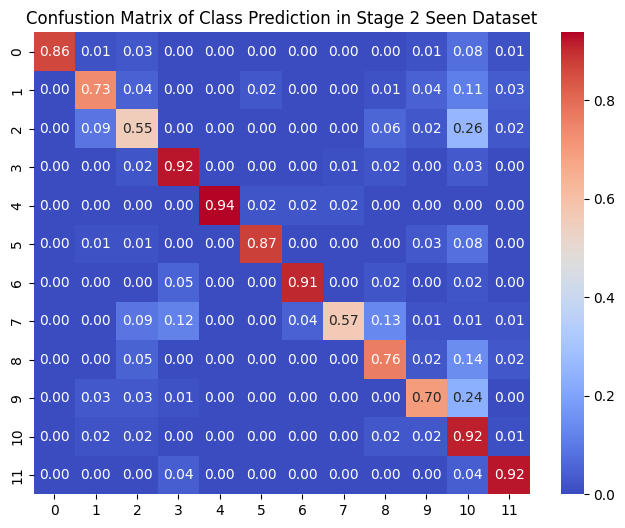

In [13]:
all_old_data_losses = np.array(all_old_data_losses)
all_new_data_losses = np.array(all_new_data_losses)
all_old_encoder_outputs = np.array(all_old_encoder_outputs)
all_new_encoder_outputs = np.array(all_new_encoder_outputs)

combined_losses = np.concatenate([all_old_data_losses, all_new_data_losses])  # All the losses for Seen and Unseen Classes Combined
combined_encoder_outputs = np.concatenate([all_old_encoder_outputs, all_new_encoder_outputs]) # All the Encoder Outputs for Seen and Unseen Classes Combined
combined_gt = actual_old_class_gt + actual_new_class_gt  # All the Ground Truth for Seen and Unseen Classes Combined
# Getting Output where the reconstruction loss to a specific AutoEncoder is minimum.


# Here we predict the clas with least reconstruction loss with the corresponding autoencoder.
predicted_old_y = np.argmin(all_old_data_losses, axis=1)
accuracy_simple_arg_min_loss = accuracy_score(actual_old_class_gt, predicted_old_y)
print("Simple Arg Min Loss Accuracy : {:0.2f}".format(accuracy_simple_arg_min_loss))

gt_old = np.zeros(len(actual_old_class_gt))
gt_new = np.ones(len(actual_new_class_gt))
gts_old_new_0_1 = np.concatenate([gt_old,gt_new])

gt_old_indices = np.where(gts_old_new_0_1 == 0)[0]
gt_new_indices = np.where(gts_old_new_0_1 == 1)[0]


cm = confusion_matrix(actual_old_class_gt, predicted_old_y, normalize='true')
plt.figure(figsize=(8, 6))
plt.title("Confustion Matrix of Class Prediction in Stage 2 Seen Dataset")
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')

Using Losses for Clustering.
Overall Split Accuracy :66.47%
Acc of Finding Old Classes belonging to Old Classes : 0.17493897477624085
Acc of Finding New Classes belonging to New Classes : 0.818974358974359


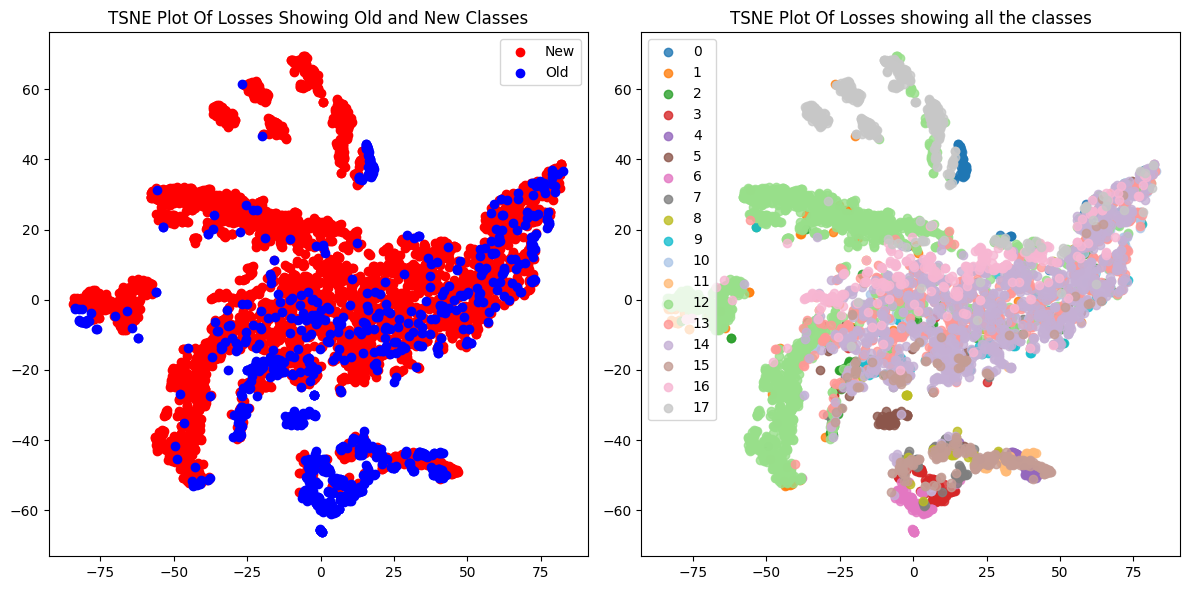

In [14]:

tsne = TSNE(n_components=2, random_state=0)
X_2d  = tsne.fit_transform(combined_losses)

# Plot 1: Scatter plot showing only Seen and Unseen classes for losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[all_old_data_losses.shape[0]:, 0], X_2d[all_old_data_losses.shape[0]:, 1], color='red')
plt.scatter(X_2d[:all_old_data_losses.shape[0], 0], X_2d[:all_old_data_losses.shape[0], 1], color='blue')
plt.title("TSNE Plot Of Losses Showing Old and New Classes")
plt.legend(['New', 'Old'])

# Plot 2: Scatter plot showing all classes for losses
plt.subplot(1, 2, 2)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
          '#c49c94', '#f7b6d2', '#c7c7c7']

for clas in range(nb_classes_now):
    clas_idx = np.where(np.array(combined_gt) == clas)
    plt.scatter(X_2d[clas_idx, 0], X_2d[clas_idx, 1], alpha=0.8, color=colors[clas])
plt.title("TSNE Plot Of Losses showing all the classes")
plt.legend([str(clas) for clas in range(nb_classes_now)])


# Doing K-Means using Losses 
print("Using Losses for Clustering.")
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto",max_iter= 500,algorithm = 'lloyd').fit(combined_losses)
outs = kmeans.predict(combined_losses)
pred_old_indices = np.where(outs == 0)[0]   # Seen Classes.
pred_new_indices = np.where(outs == 1)[0]   # Unseen Classes.

print("Overall Split Accuracy :{:.4}%".format(accuracy_score(gts_old_new_0_1, outs)*100))  # Overall Accuracy

# np.save(r'Saved_Models\Incremental\CGCD\pamap\cluster_idx_o.npy', pred_old_indices)
# np.save(r'Saved_Models\Incremental\CGCD\pamap\cluster_idx_n.npy', pred_new_indices)
print("Acc of Finding Old Classes belonging to Old Classes :", len(set(pred_old_indices).intersection(gt_old_indices))/len(set(pred_old_indices)))
print("Acc of Finding New Classes belonging to New Classes :",len(set(pred_new_indices).intersection(gt_new_indices))/len(set(pred_new_indices)))

plt.tight_layout()
plt.show()

In [15]:
# USing K-Means Clustering to predict the Old and New Class
print("Data Points belonging to Old Class = {} , New Classes = {}".format(len(actual_old_class_gt), len(actual_new_class_gt)))
gt_old = np.zeros(len(actual_old_class_gt))
gt_new = np.ones(len(actual_new_class_gt))
gts_old_new_0_1 = np.concatenate([gt_old,gt_new])

gt_old_indices = np.where(gts_old_new_0_1 == 0)[0]
gt_new_indices = np.where(gts_old_new_0_1 == 1)[0]

print("Using Encoder Outputs for Clustering.")
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto",max_iter= 500,algorithm = 'lloyd').fit(combined_encoder_outputs)
outs = kmeans.predict(combined_encoder_outputs)
pred_old_indices = np.where(outs == 0)[0]   # Seen Classes.
pred_new_indices = np.where(outs == 1)[0]   # Unseen Classes.

print("Overall Split Accuracy :{:.4}%".format(accuracy_score(gts_old_new_0_1, outs)*100))  # Overall Accuracy


np.save(r'Saved_Models\Incremental\CGCD\pamap\cluster_idx_o.npy', pred_old_indices)
np.save(r'Saved_Models\Incremental\CGCD\pamap\cluster_idx_n.npy', pred_new_indices)
print("Acc of Finding Old Classes belonging to Old Classes :", len(set(pred_old_indices).intersection(gt_old_indices))/len(set(pred_old_indices)))
print("Acc of Finding New Classes belonging to New Classes :",len(set(pred_new_indices).intersection(gt_new_indices))/len(set(pred_new_indices)))

Data Points belonging to Old Class = 921 , New Classes = 4208
Using Encoder Outputs for Clustering.
Overall Split Accuracy :82.59%
Acc of Finding Old Classes belonging to Old Classes : 0.5206489675516224
Acc of Finding New Classes belonging to New Classes : 0.8723882273646372


In [16]:
from sklearn.preprocessing import MinMaxScaler
# Just Selecting the Indices with minimim cluster distance for SplitNet module.
distances = kmeans.transform(combined_encoder_outputs)

distances[:,0] = (distances[:,0] - min(distances[:,0]))/ (max(distances[:,0]) -min(distances[:,0]))
distances[:,1] = (distances[:,1] - min(distances[:,1]))/ (max(distances[:,1]) -min(distances[:,1]))

closest_cluster_distance = np.min(distances, axis=1)

low_distances_idxs_seen = np.where(closest_cluster_distance< 0.1)[0]  # Keeping High Threshold for Seen Classes to have more seen classes
low_distances_idxs_unseen = np.where(closest_cluster_distance< 0.1)[0]  # Keeping Loww Threshold for Unseen Classes


seen_idx = 0
outs_seen = np.where(outs ==0)[0]
outs_unseen = np.where(outs ==1)[0]

seen_indices_closest_to_seen_centroid = list(set(outs_seen).intersection(low_distances_idxs_seen))  # Seen Data points that are very close to seen cluster
unseen_indices_closest_to_unseen_centroid = list(set(outs_unseen).intersection(low_distances_idxs_unseen)) # Seen Data points that are very close to ubseen cluster

all_indices = [i for i in range(len(outs))]
seen_unseen_closest_to_centroid = seen_indices_closest_to_seen_centroid + unseen_indices_closest_to_unseen_centroid
remove_indices = [idx for idx in all_indices if idx not in seen_unseen_closest_to_centroid ]

print("No of Seen Indices :", len(seen_indices_closest_to_seen_centroid))
print("No of Unseen Indices :",len(unseen_indices_closest_to_unseen_centroid))
print("No of Removed Indices :",len(remove_indices))


np.save(r'Saved_Models\Incremental\CGCD\pamap\cluster_idx_o_min.npy', np.array(sorted(seen_indices_closest_to_seen_centroid)))
np.save(r'Saved_Models\Incremental\CGCD\pamap\cluster_idx_n_min.npy', np.array(sorted(unseen_indices_closest_to_unseen_centroid)))
np.save(r'Saved_Models\Incremental\CGCD\pamap\cluster_idx_remove_min.npy', np.array(sorted(remove_indices)))

print("Acc of Finding Old Classes belonging to Old Classes :", len(set(seen_indices_closest_to_seen_centroid).intersection(gt_old_indices))/len(set(seen_indices_closest_to_seen_centroid)))
print("Acc of Finding New Classes belonging to New Classes :",len(set(unseen_indices_closest_to_unseen_centroid).intersection(gt_new_indices))/len(set(unseen_indices_closest_to_unseen_centroid)))


No of Seen Indices : 88
No of Unseen Indices : 1470
No of Removed Indices : 3571
Acc of Finding Old Classes belonging to Old Classes : 0.6704545454545454
Acc of Finding New Classes belonging to New Classes : 0.9442176870748299


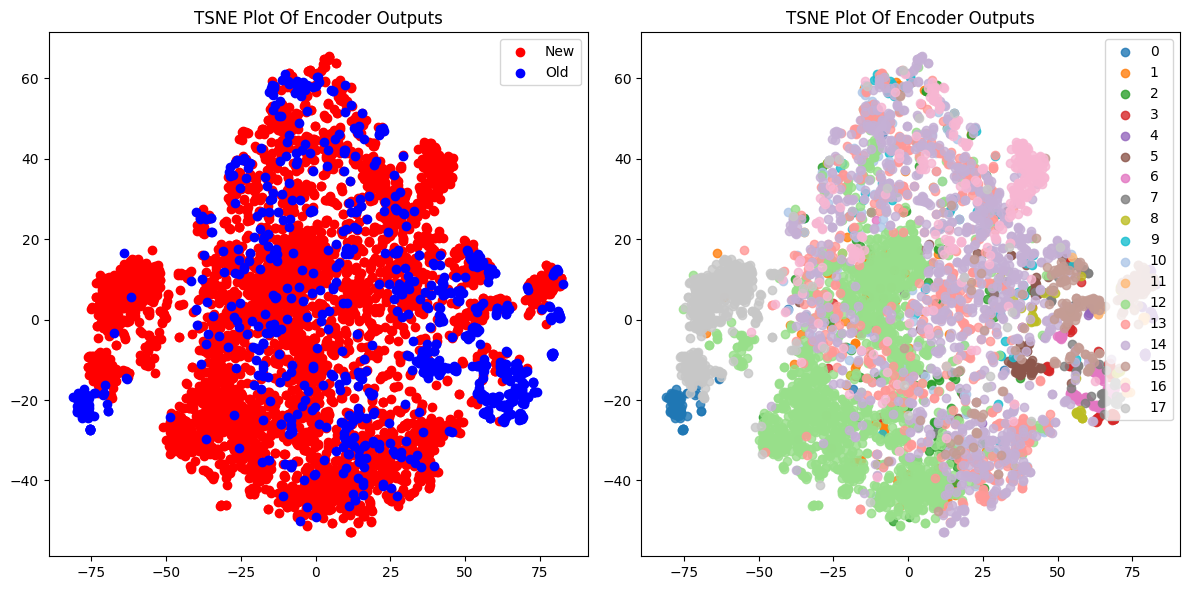

: 

In [17]:
tsne = TSNE(n_components=2, random_state=0)
X_2d_encoder_outputs  = tsne.fit_transform(combined_encoder_outputs)

# Plot 1: Scatter plot showing only Seen and Unseen classes for encoder outputs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_2d_encoder_outputs[all_old_data_losses.shape[0]:, 0], X_2d_encoder_outputs[all_old_data_losses.shape[0]:, 1], color='red')
plt.scatter(X_2d_encoder_outputs[:all_old_data_losses.shape[0], 0], X_2d_encoder_outputs[:all_old_data_losses.shape[0], 1], color='blue')
plt.title("TSNE Plot Of Encoder Outputs")
plt.legend(['New', 'Old'])

# Plot 2: Scatter plot showing all classes for encoder outputs
plt.subplot(1, 2, 2)
for clas in range(nb_classes_now):
    clas_idx = np.where(np.array(combined_gt) == clas)
    plt.scatter(X_2d_encoder_outputs[clas_idx, 0], X_2d_encoder_outputs[clas_idx, 1], alpha=0.8, color=colors[clas])
plt.title("TSNE Plot Of Encoder Outputs")
plt.legend([str(clas) for clas in range(nb_classes_now)])

plt.tight_layout()
plt.show()

In [ ]:
# # To get encoder representation of a specific Class we run the loop for each Class and get all the autoencoder representations for each element of the class and then average it
# specific_class_encoder_outputs_average = []
# for clas in range(nb_classes):
#     dset_train_0_AE = dataset.load(name=args.dataset, root=pth_dataset, mode='train_0', windowlen= window_len, transform= transform,  autoencoderType = autoencoderType)
#     y_temp = torch.tensor(dset_train_0_AE.ys)
#     data_beloning_to_a_specific_classes =  np.nonzero(torch.where(y_temp == clas, 1, 0))
    
#     dset_train_0_AE.ys = np.concatenate(list(np.array(dset_train_0_AE.ys)[data_beloning_to_a_specific_classes])).tolist()
#     dset_train_0_AE.I = np.concatenate(list(np.array(dset_train_0_AE.I)[data_beloning_to_a_specific_classes])).tolist()

#     dlod_train_0_specific_class_AE_new= torch.utils.data.DataLoader(dset_train_0_AE, batch_size=1, shuffle=False, num_workers=args.nb_workers)
   

#     specific_class_encoder_outputs = []
#     # Getting a specific class elements getting all the AutoEncoder - encoder output and then averaging them
#     for x,y, idx in dlod_train_0_specific_class_AE_new:

#         encoder_outputs = []
#         for cl in range(nb_classes):
#             trained_AE = trained_FC_autoencoders[cl]
#             trained_AE.eval()
#             encoder_outputs.append(trained_AE.encoder(x.view(-1, x.shape[1]*x.shape[2]).to(device)).to('cpu').detach().numpy())
    
#         encoder_outputs  = torch.tensor(encoder_outputs)
        
#         encoder_outputs = encoder_outputs.view(nb_classes, encoder_outputs[0].shape[1])
#         encoder_outputs = torch.cat([encoder_outputs[i] for i in range(nb_classes)], dim=0)
#         encoder_outputs = encoder_outputs.unsqueeze(0)
#         if(len(specific_class_encoder_outputs) == 0):
#             specific_class_encoder_outputs = encoder_outputs
#         else:
            
#             specific_class_encoder_outputs = torch.concat((specific_class_encoder_outputs, encoder_outputs)) 
            
    
#     specific_class_encoder_outputs_average.append(torch.mean(torch.tensor(specific_class_encoder_outputs), dim=0)) # Getting the Encoder Representation of a Specific Class
#     # encoder_outputs = np.squeeze(np.array(encoder_outputs), axis =1)
#     # encoder_average_outputs.append(np.mean(encoder_outputs, axis =0))
    


In [ ]:
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_A = np.linalg.norm(A)
    norm_B = np.linalg.norm(B)
    cos_sim = dot_product / (norm_A * norm_B)
    return cos_sim

cosine_prediction = []
for old_encoder_out in all_old_encoder_outputs:

    cosine_similarities = []
    for clas in range(nb_classes):
        
        cosine_similarities.append(cosine_similarity(old_encoder_out,specific_class_encoder_outputs_average[clas]))
    cosine_prediction.append(np.argmax(cosine_similarities))

NameError: name 'specific_class_encoder_outputs_average' is not defined

In [ ]:
accuracy_using_cosine_similarity = accuracy_score(actual_old_class_gt, cosine_prediction)
print("Cosin\ Similarity Accuracy :{}".format(accuracy_using_cosine_similarity))

Cosin\ Similarity Accuracy :0.5667752442996743


<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Dhruv\AppData\Local\Temp\ipykernel_69140\949986924.py:2: SyntaxWarning: invalid escape sequence '\ '
  print("Cosin\ Similarity Accuracy :{}".format(accuracy_using_cosine_similarity))


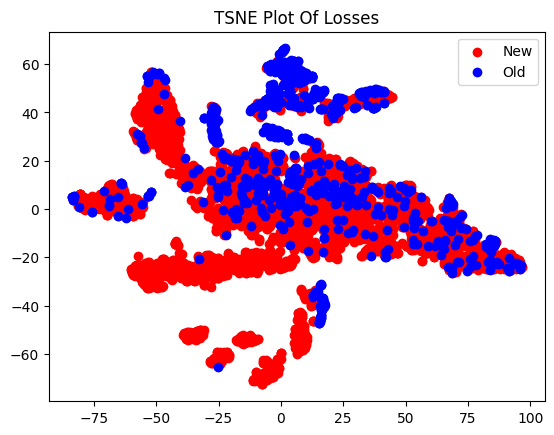

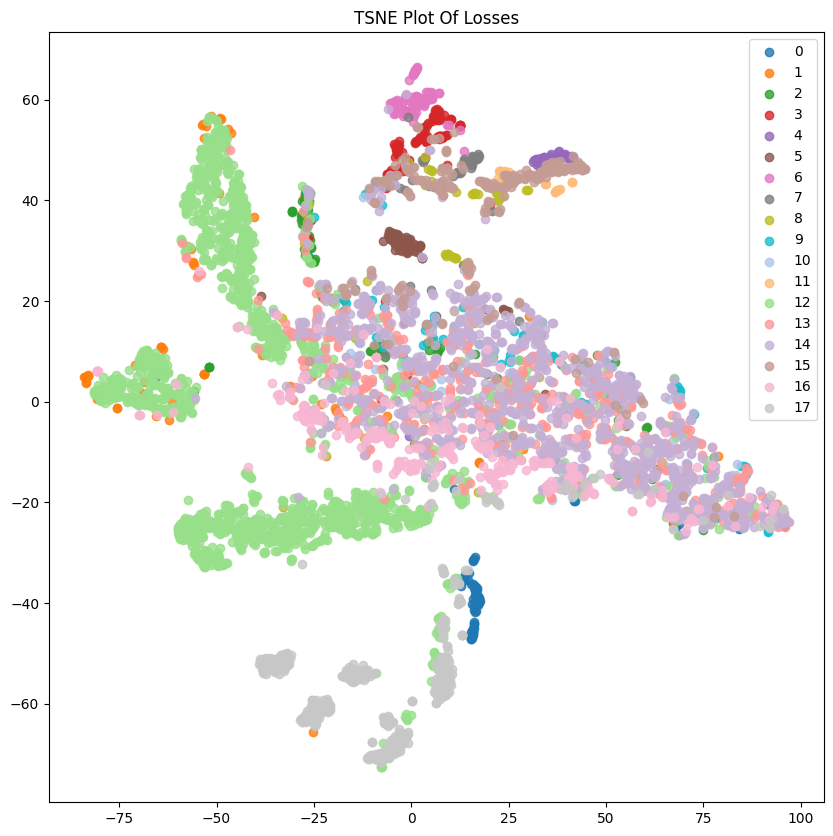

No of Old Class = 921 , No of New Classes = 4208


0.8210177422499513

Acc of Finding Old Classes belonging to Old Classes : 0.5020979020979021
Acc of Finding New Classes belonging to New Classes : 0.8726778432260988


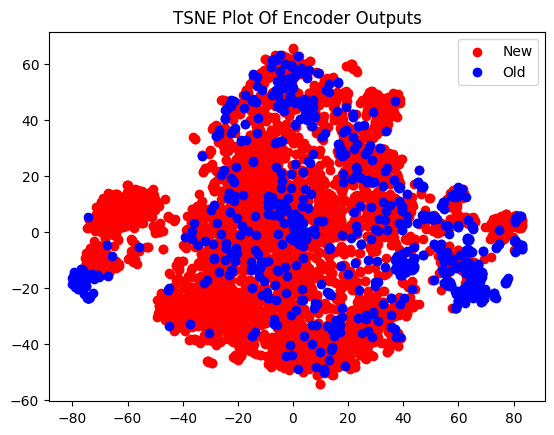

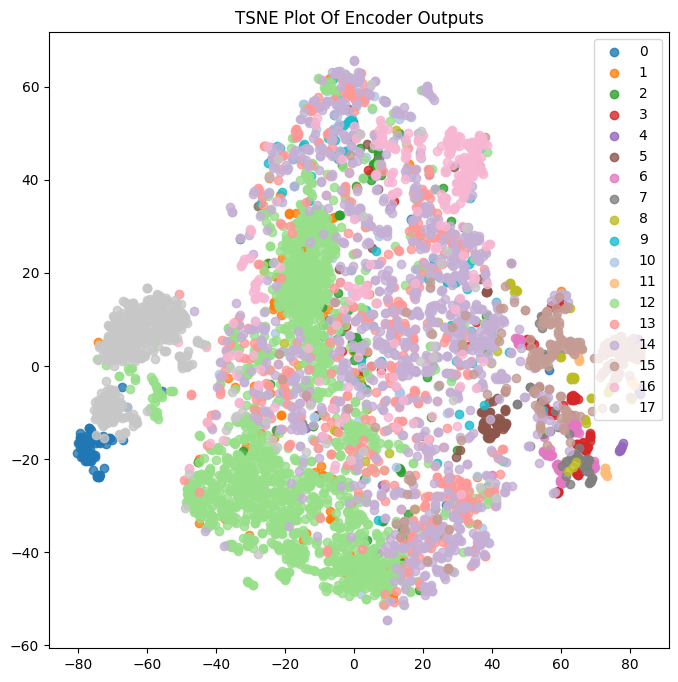